In [2]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

from torch import nn
import torch.nn.functional as F

random.seed(42)

In [3]:
data_dir = '../osic-pulmonary-fibrosis-progression'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "preprocessing")))

from preprocess import preprocess_scans
import pickle

if not os.path.exists(f'{data_dir}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir)
    pickle.dump(preprocessed_scans, open(f'{data_dir}/preprocessed_scans.pkl', 'wb'))

Using device: cuda


In [5]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [6]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

test_patient_ids = test_datas['Patient'].unique()

# Remove row in train data if patient_id is in test_patient_ids
test_datas = train_datas[train_datas['Patient'].isin(test_patient_ids)]
train_datas = train_datas[~train_datas['Patient'].isin(test_patient_ids)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
test_scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))
    
    if patient_id in test_patient_ids:
        test_scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'test', patient_id)))

test_patient_id_to_initial_FVC = test_datas.groupby('Patient')['FVC'].first().to_dict()
test_patient_id_to_initial_weeks = test_datas.groupby('Patient')['Weeks'].first().to_dict()

In [7]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

test_x, test_y = defaultdict(list), defaultdict(list)

for idx, row in test_datas.iterrows():
    test_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': test_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': test_patient_id_to_initial_weeks[row['Patient']],
    })
    test_y[row['Patient']].append(row['FVC'])


In [8]:
# Use training data to gather tabular data statistics
# Compute statistics
tabular_stats = {
    'weeks_mean': train_datas['Weeks'].mean(),
    'weeks_std': train_datas['Weeks'].std(),
    'initial_fvc_mean': train_datas['FVC'].mean(),
    'initial_fvc_std': train_datas['FVC'].std(),
    'initial_weeks_mean': train_datas['Weeks'].mean(),
    'initial_weeks_std': train_datas['Weeks'].std(),
}

print("Normalization Statistics:")
print(f"Weeks: mean={tabular_stats['weeks_mean']:.2f}, std={tabular_stats['weeks_std']:.2f}")
print(f"FVC:   mean={tabular_stats['initial_fvc_mean']:.2f}, std={tabular_stats['initial_fvc_std']:.2f}")
print(f"Weeks: mean={tabular_stats['initial_weeks_mean']:.2f}, std={tabular_stats['initial_weeks_std']:.2f}")

Normalization Statistics:
Weeks: mean=30.56, std=22.37
FVC:   mean=2696.73, std=839.28
Weeks: mean=30.56, std=22.37


In [9]:
import matplotlib.pyplot as plt
import math

# window = 0 to remove smoothing
def plot_loss(training_loss, val_loss, window=20):
    # Use sliding window to smooth the loss
    training_loss = [sum(training_loss[i:i+window]) / window for i in range(len(training_loss)-window)]
    val_loss = [sum(val_loss[i:i+window]) / window for i in range(len(val_loss)-window)]

    # Create one row, two col subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    axs[1].legend()

In [57]:
from preprocess import get_preprocessed_scan

def get_scans(patient_id: str, patient_scan_count: int, scan_batch_size: int) -> torch.Tensor:
    skip_size = patient_scan_count // scan_batch_size
    remainder = patient_scan_count % scan_batch_size
    scans = []
    curr = 0
    while curr < patient_scan_count:
        scan = get_preprocessed_scan(data_dir, patient_id, curr+1)
        if scan is None:
            continue
        scan = torch.tensor(scan, dtype=torch.float32, device=device)
        scans.append(scan)
        curr += skip_size
        
        # Ensure exactly #scan_batch_size number of scans
        if remainder > 0:
            remainder -= 1
            curr += 1
        
    scans = torch.stack(scans)
    return scans

In [11]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_model, fc_model, scan_batch_size=64):
    cnn_model.to(device)
    fc_model.to(device)

    cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0) # 1024,

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

In [12]:
# Quick visualization
def plot_test_results(targets, predictions, losses):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Left: Scatter
    ax[0].scatter(targets, predictions, alpha=0.5)
    ax[0].plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    ax[0].set_xlabel('Target')
    ax[0].set_ylabel('Prediction')
    ax[0].set_title('Predictions vs Targets')

    # Right: Loss
    ax[1].plot(losses)
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Loss')
    ax[1].set_yscale('log')
    ax[1].set_title('Loss per Sample')

    plt.tight_layout()
    plt.show()

In [13]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

def run_feature_analysis(all_features):

    # Compute pairwise distances
    features_array = torch.stack(all_features).cpu().numpy()
    distances = squareform(pdist(features_array, metric='euclidean'))

    # Heatmap of patient similarities
    plt.figure(figsize=(10, 8))
    plt.imshow(distances, cmap='coolwarm')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Patient-to-Patient CNN Feature Similarity')
    plt.xlabel('Patient Index')
    plt.ylabel('Patient Index')
    plt.tight_layout()
    plt.show()

    # Hierarchical clustering dendrogram
    linkage_matrix = linkage(features_array, method='ward')
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering of Patients (CNN Features)')
    plt.xlabel('Patient Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

    # Check if features are actually collapsed
    features_tensor = torch.stack(all_features)

    # 1. Check for dead features
    dead_features = (features_tensor.max(dim=0)[0] == 0).sum()
    print(f"Dead features (always 0): {dead_features}/{features_tensor.shape[1]}")

    # 2. Check feature value ranges
    print(f"Feature min: {features_tensor.min():.3f}")
    print(f"Feature max: {features_tensor.max():.3f}")
    print(f"Feature mean: {features_tensor.mean():.3f}")
    print(f"Feature std: {features_tensor.std():.3f}")

    # 3. Check how many features are near zero
    near_zero = (features_tensor.abs() < 0.01).float().mean()
    print(f"Percentage of near-zero activations: {near_zero*100:.1f}%")

    # # 4. Investigate the outlier patient
    # outlier_idx = 45  # Adjust based on actual index
    # print(f"\nOutlier patient: {patient_ids[outlier_idx]}")
    # print(f"Outlier features range: {features_tensor[outlier_idx].min():.3f} to {features_tensor[outlier_idx].max():.3f}")

In [14]:

def plot_patient_predict_samples(cnn_model, fc_model, criterion):
    cnn_model.eval()
    fc_model.eval()

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    # avg_loss = 0
    # for patient_id in list(train_x.keys()):
    #     scans = get_scans(patient_id, scan_count[patient_id], 64)
    #     features = torch.mean(cnn_model.forward(scans), dim=0)
    #     x = train_x[patient_id]
    #     y = train_y[patient_id]

    #     for i in range(len(x)):
    #         weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
    #         avg_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)).item()
    
    # avg_loss /= len(list(train_x.keys()))
    # print(f'Average Loss: {avg_loss}')
    with torch.no_grad():
        all_features = []
        for patient_order, patient in enumerate(list(train_x.keys())):
            scans = get_scans(patient, scan_count[patient], 64)
            features = torch.mean(cnn_model.forward(scans), dim=0)
            all_features.append(features)
            x = train_x[patient]
            y = train_y[patient]

            predictions = []
            losses = []
            for i in range(len(x)):
                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                predictions.append(output.item())
                losses.append(criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)))
            
            # print(f'{patient} Average Loss: {sum(losses) / len(losses)}')

            # # Visualize activation levels as a line plot
            # norm_weeks = (weeks - tabular_stats['weeks_mean']) / tabular_stats['weeks_std']
            # norm_initial_FVC = (initial_FVC - tabular_stats['initial_fvc_mean']) / tabular_stats['initial_fvc_std']
            # norm_initial_FVC_weeks = (initial_FVC_weeks - tabular_stats['initial_weeks_mean']) / tabular_stats['initial_weeks_std']
            # tab_features = torch.cat([norm_weeks, norm_initial_FVC, norm_initial_FVC_weeks])
            # tab_features = F.relu(fc_model.tabular_expansion_fc1(tab_features))
            # tab_features = F.relu(fc_model.tabular_expansion_fc2(tab_features))
            # combined_features = torch.cat([features, tab_features])
            
            # feat = fc_model.fc1(combined_features)
            # feat = F.relu(feat)
            # feat = fc_model.fc2(feat)
            # feat = F.relu(feat)
            # print(feat)
            # feat = fc_model.fc3(feat)

            # How does 'week' feature affect the prediction?
            # weeks = torch.tensor(0, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_0 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # weeks = torch.tensor(50, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_50 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # weeks = torch.tensor(100, dtype=torch.float32, device=device).unsqueeze(0)
            # pred_week_100 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
            # print(pred_week_0.item(), pred_week_50.item(), pred_week_100.item())
            if patient_order < 4:
                row = patient_order // 2
                col = patient_order % 2

                # Plot prediction vs actual for each patient
                axes[row][col].scatter(range(len(y)), y, color='blue', alpha=0.7, s=80, label='Actual', edgecolors='darkblue', linewidth=0.5)
                axes[row][col].scatter(range(len(predictions)), predictions, color='red', alpha=0.7, s=80, label='Predicted', edgecolors='darkred', linewidth=0.5)
                
                axes[row][col].set_xlabel('Timepoints', fontsize=11, fontweight='bold')
                axes[row][col].set_ylabel('FVC', fontsize=11, fontweight='bold')
                axes[row][col].set_title(f'Patient {patient}', fontsize=12, fontweight='bold', pad=10)
                axes[row][col].legend(loc='best', frameon=True, shadow=True)
                axes[row][col].grid(True, alpha=0.3, linestyle='--')
                axes[row][col].tick_params(labelsize=10)

    run_feature_analysis(all_features)

    # # Do inter-patient scan feature analysis
    # scan_feat_mean = torch.mean(torch.stack(all_features), dim=0)
    # scan_feat_std = torch.std(torch.stack(all_features), dim=0)
    # print(f'Across patients, scan feat mean = {scan_feat_mean}, scan feat std = {scan_feat_std}')

    # Add spacing between subplots
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)

    # Or alternatively, use subplots_adjust for more control:
    # plt.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95, hspace=0.3, wspace=0.3)

    plt.suptitle('FVC Predictions vs Actual Values', fontsize=16, fontweight='bold', y=0.995)
    del weeks, initial_FVC, initial_FVC_weeks, predictions, scans, features, output
    torch.cuda.empty_cache()
    plt.show()


In [15]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=32):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate gradient for 8 datapoints for each patient
            # total_loss = 0
            # patient_scan_count = scan_count[patient_id]
            # scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            # for i in range(0, len(x), 4):
            #     optimizer.zero_grad()
            #     features = cnn_model.forward(scans)
            #     features = torch.mean(features, dim=0) # 1024,
                
            #     chunk_loss = 0
            #     for j in range(i, min(len(x), i+4)):
            #         weeks = torch.tensor(x[j]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            #         initial_FVC = torch.tensor(x[j]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            #         initial_FVC_weeks = torch.tensor(x[j]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            #         # Forward Pass
            #         output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            #         loss = criterion(output, torch.tensor(y[j], dtype=torch.float32, device=device))
            #         chunk_loss += loss
            #         total_loss += loss.item()

            #     chunk_loss.backward()
            #     optimizer.step()
            
            total_loss = 0
            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            for i in range(len(x)):
                optimizer.zero_grad()
                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0) # 1024,

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()

            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

### Baseline Model with 5 Convolution Layers

In [18]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.bn1(self.conv1(scans)))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x) # num_slices, 512, 8, 8

        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)


        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [73]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_simple_cnn.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=20, scan_batch_size=64)

Epoch 0


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 0 completed
Training Loss: 201816.01791205633
Validation Loss: 721079.880237325
Epoch 1


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 1 completed
Training Loss: 502626.1520631821
Validation Loss: 304410.2135704189
Epoch 2


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 2 completed
Training Loss: 64171.100812324534
Validation Loss: 107570.90302025902
Epoch 3


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 3 completed
Training Loss: 61127.874334086315
Validation Loss: 79289.03445887248
Epoch 4


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 4 completed
Training Loss: 112664.8962776449
Validation Loss: 112998.21478851319
Epoch 5


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 5 completed
Training Loss: 41709.28348974784
Validation Loss: 73736.71894794147
Epoch 6


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 6 completed
Training Loss: 103477.38801123074
Validation Loss: 54644.43035713646
Epoch 7


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 7 completed
Training Loss: 45914.78552028868
Validation Loss: 54140.02369616615
Epoch 8


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 8 completed
Training Loss: 56157.907446522186
Validation Loss: 76053.5128076511
Epoch 9


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 9 completed
Training Loss: 57716.56013205847
Validation Loss: 53450.479450433515
Epoch 10


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 10 completed
Training Loss: 25237.736510687937
Validation Loss: 52757.26427754747
Epoch 11


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 11 completed
Training Loss: 20895.160103058814
Validation Loss: 59981.77643124686
Epoch 12


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 12 completed
Training Loss: 40695.86138066185
Validation Loss: 60443.51360255771
Epoch 13


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 13 completed
Training Loss: 82604.84121311188
Validation Loss: 50754.16986374378
Epoch 14


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 14 completed
Training Loss: 44013.115658563285
Validation Loss: 49145.32045108908
Epoch 15


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 15 completed
Training Loss: 68923.78140409259
Validation Loss: 60432.78392880606
Epoch 16


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 16 completed
Training Loss: 52790.63551663611
Validation Loss: 95792.13201541477
Epoch 17


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 17 completed
Training Loss: 39105.13443303638
Validation Loss: 52160.0744310909
Epoch 18


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 18 completed
Training Loss: 57638.160543478865
Validation Loss: 48743.689501373505
Epoch 19


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 19 completed
Training Loss: 81977.89489631983
Validation Loss: 56916.187700051196


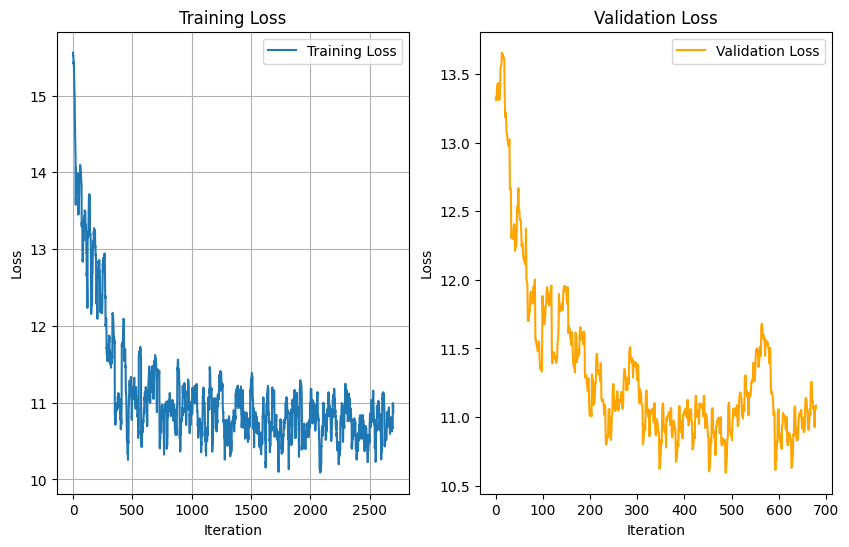

In [74]:
plot_loss(training_loss, val_loss)

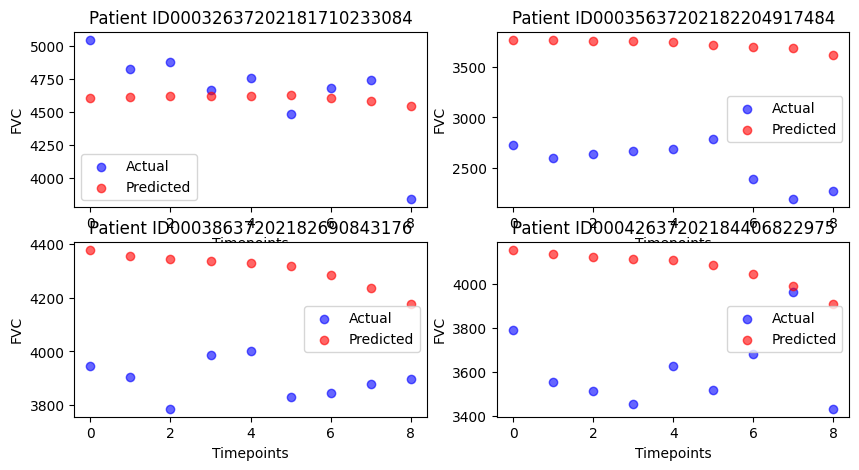

In [88]:
plot_patient_predict_samples(cnn_model, fc_model)

100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


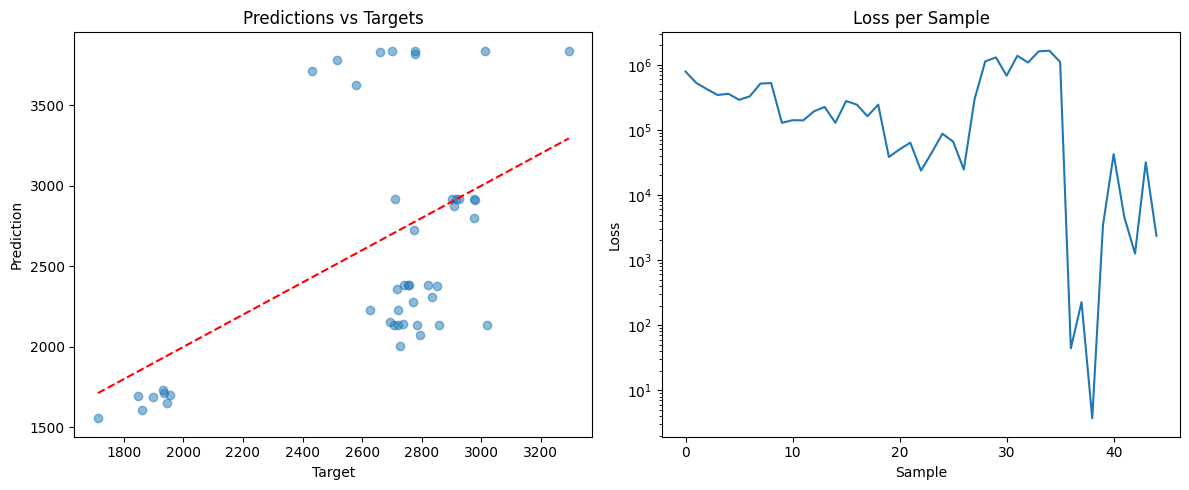

In [78]:
test_prediction, test_target = test_model(cnn_model, fc_model)
criterion = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [criterion(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

### Improvement to Baseline: Increased convolution layers using sequential blocks

In [22]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2, stride=2)
        self.pool1 = nn.MaxPool2d((3,3), stride=(2,2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            # nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 128, 128
        x = self.pool1(x) # num_slices, 64, 64, 64

        x = self.conv2(x) # num_slices, 64, 64, 64
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)


        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Denormalize the output
        x = x * self.initial_fvc_std + self.initial_fvc_mean

        return x

In [ ]:
# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, criterion, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=64, patient_batch_size=4):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.AdamW(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # betas=(0.95, 0.999)
        # weight_decay=1e-5  # L2 regularization
    )

    cnn_grad_norms = []
    fc_grad_norms = []

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]
            # if patient_count % patient_batch_size == 0:
            total_loss = 0
            optimizer.zero_grad()

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            # cnn_grad_norm = 0
            # fc_grad_norm = 0
            for i in range(len(x)):
                optimizer.zero_grad()
                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0) # 1024,

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                total_loss += loss.item()

                loss.backward()
                # torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=1)
                # torch.nn.utils.clip_grad_norm_(fc_model.parameters(), max_norm=1)


                # cnn_grad_norm += sum(p.grad.norm().item() for p in cnn_model.parameters() if p.grad is not None)
                # fc_grad_norm += sum(p.grad.norm().item() for p in fc_model.parameters() if p.grad is not None)
                
                optimizer.step()

            # if patient_count % patient_batch_size == patient_batch_size - 1:
            #     # Gradient clipping
            #     torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=0.5)
            #     torch.nn.utils.clip_grad_norm_(fc_model.parameters(), max_norm=0.5)

            #     optimizer.step()

            patient_count += 1

            # Check gradient norms
            # cnn_grad_norms.append(cnn_grad_norm / len(x))
            # fc_grad_norms.append(fc_grad_norm / len(x))
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    # print(cnn_grad_norms)
    # print(fc_grad_norms)
    return training_loss, val_loss

In [36]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_seqblkcnn.txt'
criterion = nn.HuberLoss(delta=1.0)

training_loss, val_loss = train_model(cnn_model, fc_model, criterion, log_file, epoch=5, scan_batch_size=64, learning_rate=0.0001, patient_batch_size=1)

Epoch 0


100%|██████████| 136/136 [01:26<00:00,  1.58it/s]


Epoch 0 completed
Training Loss: 160.93862630208332
Validation Loss: 200.7035309516059
Epoch 1


100%|██████████| 136/136 [01:26<00:00,  1.57it/s]


Epoch 1 completed
Training Loss: 323.1614841037327
Validation Loss: 263.11201432651944
Epoch 2


100%|██████████| 136/136 [01:25<00:00,  1.58it/s]


Epoch 2 completed
Training Loss: 227.91741672092013
Validation Loss: 320.41800211588543
Epoch 3


100%|██████████| 136/136 [01:25<00:00,  1.59it/s]


Epoch 3 completed
Training Loss: 201.59695943196613
Validation Loss: 295.54339206271703
Epoch 4


100%|██████████| 136/136 [01:24<00:00,  1.60it/s]


Epoch 4 completed
Training Loss: 189.88090004088386
Validation Loss: 249.74035868326823
[119980.7885680033, 37278.11510660107, 29485.403301206883, 20708.87869151022, 19941.95769078906, 18579.656903739284, 15470.468224608507, 13342.351471354445, 12856.3178481404, 13641.648504733286, 14091.305059128621, 12321.745670337872, 11328.297675517031, 11623.125991337523, 11507.085405541522, 11666.066631373898, 11737.301243509399, 11691.203390488783, 11966.832430155055, 9576.102674089996, 9692.772250593487, 9535.207996842351, 8128.6220299022325, 10030.059802570933, 8467.403597736567, 8901.528293314215, 7981.186108519604, 8231.554731787284, 9277.084507610383, 10248.544621542467, 7221.593588264695, 7644.918590536755, 6689.629537497469, 5916.012879695066, 6031.882633317921, 8488.55908348952, 6630.791367635732, 6457.3538766365455, 6748.689802724311, 9692.854359885361, 6051.840670131396, 5696.666740246285, 8180.160963734845, 6610.923679529612, 5850.861004559323, 7458.719745041466, 5866.5458373292095, 6

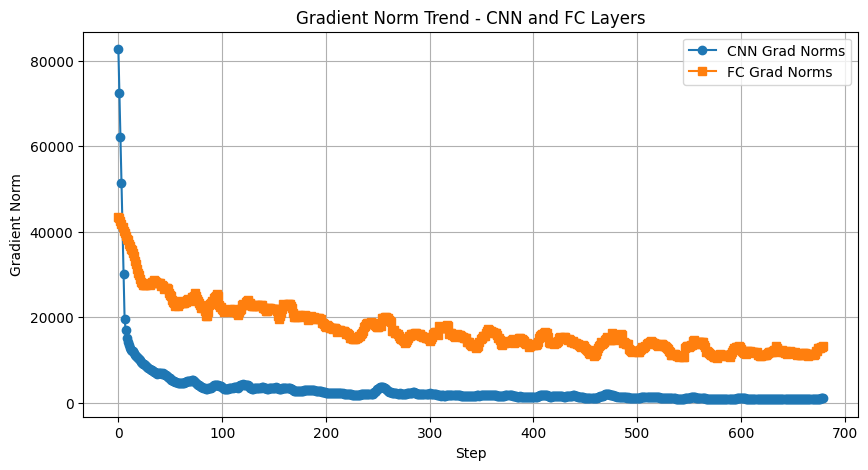

In [41]:
cnn_grad_norms = [119980.7885680033, 37278.11510660107, 29485.403301206883, 20708.87869151022, 19941.95769078906, 18579.656903739284, 15470.468224608507, 13342.351471354445, 12856.3178481404, 13641.648504733286, 14091.305059128621, 12321.745670337872, 11328.297675517031, 11623.125991337523, 11507.085405541522, 11666.066631373898, 11737.301243509399, 11691.203390488783, 11966.832430155055, 9576.102674089996, 9692.772250593487, 9535.207996842351, 8128.6220299022325, 10030.059802570933, 8467.403597736567, 8901.528293314215, 7981.186108519604, 8231.554731787284, 9277.084507610383, 10248.544621542467, 7221.593588264695, 7644.918590536755, 6689.629537497469, 5916.012879695066, 6031.882633317921, 8488.55908348952, 6630.791367635732, 6457.3538766365455, 6748.689802724311, 9692.854359885361, 6051.840670131396, 5696.666740246285, 8180.160963734845, 6610.923679529612, 5850.861004559323, 7458.719745041466, 5866.5458373292095, 6905.305757669111, 6347.3150464248865, 6134.488017902942, 5115.809298492933, 5326.829178395552, 5051.79909603384, 4829.804521136728, 4632.6380731499685, 4326.159018320653, 5411.7519326126385, 4474.46669671169, 5226.587356932949, 4443.812251593135, 4907.912539698352, 4110.490757497458, 4881.958793803571, 4906.324647319365, 3930.08990713032, 4254.17334467571, 4558.669340900715, 5241.794180741844, 7746.358897299273, 5387.620925140205, 5335.098075243306, 4904.743751811229, 4455.624939641739, 4721.780005436603, 5576.765988654767, 4523.221302525593, 5657.711069703532, 3941.976397043642, 4291.678673373147, 3190.6413550710568, 3051.7768258352685, 3468.02785099231, 3314.4323740346817, 3100.127474950144, 2970.3759191601325, 3883.3597743764485, 3035.238002698001, 3401.4674570049337, 3388.0892747979574, 3217.142163664405, 3814.633914037813, 4994.595814724925, 3703.8401097506867, 3295.4747910881656, 3718.878396999726, 6185.407032298063, 6393.385792647857, 3584.0595102181187, 3143.31744795994, 3545.125257687449, 3451.6901651371027, 2766.204238830045, 3024.493522020284, 3027.1052191007216, 2952.502269541221, 3090.447107580327, 3921.8631364619227, 3679.47814604491, 3557.907870154815, 3793.303367574221, 3465.7552973606757, 3564.7083909790317, 4090.9344682239607, 3429.2419191772724, 3010.213333764676, 4944.523427640463, 3265.879970826065, 2978.335417574912, 3589.989978586013, 3299.3640081328435, 6373.193492714937, 7016.092935481057, 4526.724880528662, 3654.090072402061, 3499.821759655986, 3394.0692588949523, 3417.4115860411193, 3346.3768382099743, 3502.577572258448, 4123.949828969222, 3136.100676677617, 3067.6099257677106, 2938.8127678880505, 2983.251643610505, 3466.4725445989043, 3856.1976406595527, 3535.349882835286, 4482.673975650629, 3937.827571829681, 3308.1904162678466, 3272.8015161094713, 3749.7256256468568, 3406.298023518527, 2996.8391159933144, 2970.9157226579973, 3119.858316286493, 2710.208649371966, 3665.8665523719296, 4319.356545340929, 3826.0819515814474, 3133.4865807540355, 4851.391650328762, 3814.5097217026305, 2839.3190722644867, 3222.1169588338325, 3084.8245366690912, 3584.969203378081, 3122.960085068784, 2794.4893093394107, 2525.268868132087, 3563.2004838418798, 4830.0170979146305, 4657.303388078322, 4025.250365531263, 2841.5486743091315, 2609.168919611486, 3457.112424811051, 2690.2676217070516, 2516.551289787368, 2499.4554446220695, 3377.2473058658816, 2868.880904078367, 2576.3133251943914, 2501.3319213150016, 2335.308733593507, 3201.820442377344, 2556.8760282508892, 2929.432614402221, 2564.2416086527032, 2818.406146907422, 3293.6184454637373, 3363.537307869009, 3172.40329308965, 2675.0919973528944, 3950.852869352009, 2874.4232020885684, 2847.139906360244, 2413.784604087585, 3168.8619628741612, 2523.6803884554956, 3580.103145213099, 2966.52584009236, 2122.7162761588, 3244.6455102842947, 2932.5983073866614, 2535.119683883362, 2603.145475167335, 2483.503412957065, 2497.868677535715, 2305.966287843386, 2205.3300591457405, 2045.6814313692255, 2540.561457411302, 2210.2651894699698, 2485.2912198096165, 2571.0341077109456, 2514.205585885922, 2128.3472012407383, 2162.580238328519, 2086.835508179878, 2164.472956296659, 2147.1739836559345, 2144.882507072693, 2444.8154637139432, 2399.5704467776814, 2163.647082372787, 2483.799247916689, 2307.3581570105516, 1978.2989717234013, 2078.8051978798853, 1871.370297692632, 1956.0132949954148, 2060.337259608193, 2030.0674785168044, 2118.5947108134797, 2030.3448714426163, 1925.238409823895, 1716.2253364477099, 1798.3945441692874, 1884.723935103534, 1977.7340370995744, 1771.444789388715, 1984.5092726110952, 1941.835509497243, 1769.8905734732507, 2431.509337866637, 1836.2664202521473, 1777.5623432551288, 2198.908727365495, 2039.5982543200485, 2104.8230505441566, 1931.0086005693365, 2142.53305036526, 1996.86441662803, 2370.995158603337, 2173.897773572193, 2081.3495366166253, 2027.6567517452797, 2083.0653775834435, 1794.3181889737518, 5963.759447082499, 2676.0260912853973, 4333.793647599829, 5882.972457699128, 4304.508200615489, 3613.157190877071, 3425.896403115223, 2204.210347737643, 2958.3197195133835, 2556.187477772137, 2483.211604861607, 2180.1248728392384, 3102.7849046908864, 3420.595660115356, 1918.9664168421853, 1890.0502961519855, 2374.390270899279, 1910.9948166338452, 2313.254052606164, 2487.0762646478706, 2290.471476318745, 1951.9183839825628, 2009.492667836411, 2338.3335431351475, 2315.5531502152508, 2404.7887525286255, 1638.627927670644, 1681.0307196949543, 1768.9345925587177, 2119.3711578769194, 2296.599841266618, 2262.4169924940184, 3893.20620259067, 2314.1282247930067, 2051.510335777644, 2365.8054293067607, 2258.686252860818, 2810.0090816663287, 1918.509143806205, 2153.6018091323285, 1751.1066774414535, 1838.9631267618565, 2234.7489307535775, 2150.52038807163, 1920.6630661198199, 2629.9361387298754, 1670.6334504823378, 2116.3178591571505, 2465.8494424656255, 1512.1200520619886, 2405.4443276055263, 2156.264013508781, 1653.5913814263358, 2704.0914845986085, 2753.830817766421, 2282.096884149054, 1742.295011021969, 1751.1674473657804, 2415.3236013111245, 1483.324128890691, 1453.0525646783449, 1271.839259713701, 1491.8680980422773, 2280.2326455558027, 1691.8352713204602, 1456.6989942492987, 2043.7093328708054, 1750.0835351713952, 1878.6344869420006, 1857.4845165045845, 1789.0384917973975, 1704.9608912767935, 1475.3479850946605, 1662.2579217665964, 1761.038895280605, 1932.7570102425007, 1600.7701374461492, 1684.957619315285, 1864.4149974948439, 2122.7786684531893, 1897.3827682865765, 1592.490996024547, 1380.891895735849, 1431.6588549271607, 1645.5707993556216, 1369.3886896162996, 1364.9279321571337, 1603.4468103919771, 1572.9259099226701, 1540.099272787887, 1374.623076756142, 1804.6006628768455, 1917.9131392224226, 1662.1721159327458, 1895.7854183588383, 2095.577615691109, 1431.6292729460365, 1583.9182058482547, 1373.2888041156386, 1773.3736159995703, 1933.951526849382, 1594.6463462351333, 1803.5964624817295, 2134.9335910404916, 1865.1569294661006, 2073.0354910368915, 2025.709909269493, 1668.9607897268133, 1888.3763687831783, 2161.339927004604, 1841.3827521813598, 1646.051181871839, 1550.7387846394558, 1738.890049372043, 1648.2566821988958, 1748.3811039893517, 1608.7095400120727, 1495.599574768987, 1848.71379146853, 1473.7526016758243, 1762.221258188627, 1484.6866881576975, 1267.8432028356017, 1832.2192195829184, 1685.3913672796011, 2427.6494716196257, 1579.4822963592221, 2055.529100611754, 2356.8596274213246, 1484.8163927835137, 1703.080936305655, 1259.26251721284, 1468.1993244124137, 1409.0254941579058, 1408.357956072128, 1358.2388720449846, 1510.372731608203, 1417.8427262171947, 1729.2533691064923, 1488.9426638494576, 1800.170879021287, 1588.0545191307392, 1156.2886619864646, 1233.5474499154277, 1430.6501234056293, 1189.8476873526247, 1218.861599955897, 1345.7555140520817, 1770.3121040121705, 1472.8963800610436, 1223.8635807215724, 1318.1760709058242, 1344.3267703493848, 1585.7241711874765, 1381.1355692931575, 1154.2161584346622, 1332.5732696735322, 2067.6832026454717, 2793.081411086023, 2442.7214982401474, 3093.095257412319, 1283.305744068511, 1282.8526303312055, 1490.5088799641655, 1826.5862746276737, 1402.194482551144, 1449.1581879568791, 1622.2880001503581, 1309.103916316539, 1279.5900782934914, 1178.652726729478, 1666.0479473143803, 2118.830077604612, 1680.8679428376574, 1713.9263155820922, 1416.7479428956422, 1654.2515606585139, 1445.740792008373, 1389.5563880083905, 1498.8587829444473, 1327.6460467902623, 1436.089654495002, 1334.7773420225349, 1423.645114656224, 1841.3453352645738, 1825.5539716291241, 2346.199321664456, 1307.0862484251031, 1859.0256976693117, 1742.304565010851, 1550.2574248447652, 1605.1491839914847, 1905.5288271574666, 1454.2544357535269, 1317.9851330638874, 1251.3135650297093, 1068.3413235713442, 1078.4867118329826, 1163.5611542801764, 1048.5411959403095, 1401.6730566018248, 1389.570289809716, 1400.6919819030586, 998.0780288339274, 1264.3287869859746, 870.8660987752164, 1086.9420694455807, 1135.420307811609, 1130.083497707836, 999.3639055304092, 1178.4873473220355, 1174.3575406354169, 1165.579726815461, 1408.948235617594, 1584.6861537272343, 1417.0668830310137, 1466.3803119200045, 2396.596984565814, 2683.1586662187715, 1752.6195349480777, 1640.5234415623677, 1681.1354618146952, 2739.9881126006494, 3101.792376848258, 1587.3730947110064, 1879.508436875088, 1328.7399613073567, 1608.1273379405548, 1489.6726080807186, 1226.1029748979417, 1940.3942847932922, 1319.6008247782956, 1537.2287025111016, 1474.9680382850815, 1427.0514087348065, 1169.8141568975416, 1675.204218201915, 1111.001482842099, 1525.268079184671, 1121.4306335170277, 1217.9721543318528, 1253.3140022574892, 1260.003778438871, 882.9400986262449, 1179.1854960396147, 1341.0194739015521, 1123.8158526125756, 898.9653847176903, 1041.5083227079708, 1197.5233357306472, 1147.6425186646327, 1033.975544002638, 1385.7044970868737, 1236.2221291301732, 1061.99688242733, 1060.3148433231418, 1238.497770592787, 1306.8086541365312, 2306.726450750614, 1864.0662721248389, 1051.642065771927, 1357.8685789315314, 1032.5737709513587, 1281.2979252409054, 1519.0743030030362, 1329.8049623265833, 1532.0083480933454, 1322.3830589544627, 1084.5283498206566, 1255.5926690335555, 1181.1821403999359, 1020.7754147134128, 1239.523047549187, 1071.1568631018408, 1609.5106224063202, 1228.0973103125216, 1099.7908822744046, 1129.3991456173696, 1324.1006034493637, 1025.0076281661466, 1257.45396429631, 941.4173987996514, 1287.5605756460445, 1158.8324581891688, 970.0971454578838, 818.0441546579908, 925.591826401779, 1056.3691586462062, 1092.8769015026385, 993.8406137115783, 981.6436901909025, 883.8082492203489, 1015.821180430837, 922.6420376645498, 900.5127608078781, 1216.4287315954232, 961.428900736106, 1080.738046343431, 1197.6631606074716, 990.3318974462309, 1759.9150670033866, 1490.272879915734, 1005.7932921672772, 985.7309262975436, 1006.7455765405243, 1068.0153738990307, 2217.3182384865904, 1127.1726272919311, 1230.0082442507191, 1135.7394845747883, 1332.4206240526373, 1028.4542752709904, 1118.809371256305, 1109.8406627125432, 994.9414943146544, 1128.3793969181845, 884.7361891249436, 964.459396826372, 889.263089894434, 916.3636271941427, 875.7374694332442, 967.6001702256892, 744.3608832176927, 968.2306459249206, 779.1860619699728, 901.1244647362086, 1270.9015980813904, 854.8169530786449, 841.4437640531227, 925.9816310132657, 1025.9439398614122, 965.1556673638341, 926.7991937978142, 961.2630963939664, 913.1740499163093, 876.1998097885498, 790.2728781492125, 909.1168506110566, 830.1871730340746, 887.3671854746657, 1030.2901755479897, 946.3749781695037, 911.3107928596559, 795.080348845941, 1119.8614384682514, 1154.4865978350338, 1104.6297076888418, 900.8602093962998, 895.405823260245, 1133.5474646570083, 1340.0517936973629, 1153.4464185809338, 1182.858326346653, 968.9538971466633, 1025.3107318263656, 840.2098121053116, 854.4827875681056, 952.9517410766696, 789.0688251782786, 1030.4683453247353, 1061.2777051811504, 1082.933628156601, 881.4099575185651, 1086.306326420171, 747.4330047969811, 873.2729566707081, 1134.4317148812436, 893.8595847018295, 794.8772758723151, 1055.5726352308625, 963.0301924817645, 853.0913150092238, 760.0610310719617, 966.1525703657426, 858.8002007109419, 903.3531260165478, 719.8842880212092, 771.0159299571819, 876.8188533116477, 1196.6620104224633, 1064.3920390878984, 1251.2683010375233, 800.3151640796067, 811.7271348673228, 800.0065232289611, 1163.9187130697183, 1058.7797483701079, 928.6391643109013, 1019.1218765818763, 984.9641020537424, 902.6929035550828, 827.382103527214, 924.9469052051799, 1156.1149854153628, 944.8921466476108, 833.5849945136628, 785.3816982375057, 1109.443166947251, 988.9487228259709, 1455.9402106420687, 985.0875871223341, 969.7049552303256, 865.279453325787, 873.3268298899679, 799.7467449134601, 881.0656332432004, 794.1941149667351, 1363.1305292745644, 895.6439956086623, 888.635685232166, 786.693759008253, 820.9224342840207, 735.8855756058356, 823.9495267969885, 834.740364833439, 1451.5426926747568, 998.6745970708034, 661.2167793919248, 731.5371682972244, 742.0715560470107, 1137.8019615443966, 863.3642443096531, 807.5582309296458, 934.3683642443697, 861.7404440039666, 839.3219289599115, 924.7739465365643, 797.4337557025738, 907.4994590224313, 1488.2589177027662]
fc_grad_norms = [44234.60158252716, 42404.2243025038, 44876.78743150499, 40082.80702209473, 42320.63407304552, 40746.84729003906, 38522.56400553385, 36032.899085998535, 37276.03327433268, 35985.26428731283, 38854.87998199463, 35079.19466484917, 37629.78031921387, 37739.23824818929, 33733.59337192112, 35036.678249782984, 33064.02310858833, 33408.63261244032, 31057.17534383138, 27404.38322666713, 27266.40394083659, 28418.921120779854, 25808.9194132487, 28644.969751993816, 27990.816804885864, 27121.997579574585, 26581.651104397242, 30816.172590255737, 26625.6137169732, 27414.599605560303, 26573.346755981445, 28036.609937879773, 27728.447179158527, 29861.327984280055, 24464.8837246365, 33078.12828233507, 28231.194474962023, 30190.333263397217, 32488.879287719727, 25206.23377143012, 23040.648936680383, 25161.859502156574, 27977.946460300023, 30121.492448594836, 24676.101101345484, 25635.869532267254, 30864.17129855686, 27521.090866088867, 25025.449381510418, 28769.041178385418, 23718.15184020996, 24365.13820054796, 25141.538828531902, 20505.890420913696, 21530.900331285266, 22752.394387139215, 21759.500586615668, 21933.54549323188, 22649.811456680298, 22832.829735649957, 24599.760009765625, 23930.645233154297, 28657.30399746365, 26502.87786102295, 19889.97592671712, 20238.226976182727, 21974.649841308594, 22284.320436265734, 24097.136472702026, 24894.413226657445, 27013.922328948975, 26353.31231689453, 26604.787319607203, 24277.776977539062, 25692.552052815754, 23406.067353990344, 22904.46939086914, 25293.117441813152, 30179.02724202474, 18657.164642333984, 18747.479393853082, 23571.99068705241, 21585.69797261556, 19701.510379367406, 17956.07817586263, 26263.64656745063, 19490.560718112523, 18833.447635650635, 19111.224113464355, 18901.665693495008, 27030.154791937934, 40010.192377726235, 23905.90737745497, 20986.39031982422, 23422.042861938477, 24982.108900282117, 28710.748226589625, 21173.800448947484, 20817.09776687622, 23991.552035861547, 22348.52505493164, 17927.132468753392, 20006.37700059679, 20463.333506266277, 20173.01387532552, 21568.455678304035, 24700.273599243163, 21728.334478759767, 22561.443873087566, 24958.572057088215, 20852.579387119837, 19568.390918307836, 22060.01296043396, 17235.42572869195, 18205.407777574328, 28181.490478515625, 22224.415300369263, 16094.926475524902, 21280.331707424586, 19554.94312201606, 28651.126675075953, 24322.64936319987, 23429.649317423504, 25918.93278312683, 22735.056339263916, 23721.491863674586, 23109.551183064777, 23330.887500339086, 24180.90046013726, 22308.447149658205, 21159.400449117024, 22687.819783528645, 20554.95776706272, 23797.22004530165, 22226.88902452257, 22755.985580444336, 25911.42490005493, 21951.739998953683, 26207.72317843967, 21228.17436726888, 19775.6997918023, 25051.803131103516, 19646.471672058105, 18143.298069000244, 20286.48346625434, 21500.427023993598, 21114.24560038249, 22958.00250583225, 31286.85302225749, 23294.79507446289, 19087.668831719293, 21593.909342447918, 19530.75598526001, 17968.927354812622, 20944.999372694227, 20999.922399902345, 22011.781311035156, 18858.113321940105, 18520.54180908203, 17106.53941429986, 25474.136018541125, 29471.58391655816, 29333.37949625651, 27804.088133070203, 19209.592975616455, 19408.78860982259, 22700.29791937934, 21156.362163967555, 19026.039547390406, 18522.939387730188, 18803.48243882921, 25392.836212158203, 18723.46480645074, 18323.321277194555, 19688.635226779516, 21824.538640340168, 19235.3956451416, 25749.878287421332, 17935.4190504286, 19982.30131149292, 17459.723773532445, 22491.93927001953, 20196.381129673548, 18422.07816229926, 22032.595428466797, 19555.733527289496, 16777.14394378662, 18622.42246839735, 21685.065500895184, 20213.54974746704, 23846.315205891926, 16780.20628696018, 17634.919308132594, 22666.33049858941, 20396.2305738661, 16998.64757792155, 19692.94617377387, 19674.75233629015, 19003.292809380426, 18762.795323689777, 16242.667310926648, 15351.663333468967, 15185.4191470676, 18016.98826429579, 17984.610836452906, 22843.007381863063, 16040.6577996148, 19015.31632147895, 15286.155123029437, 18256.727669609918, 16379.452824401855, 14881.598046196832, 16048.208046807184, 17374.93806118435, 16259.837553024292, 16504.204511854383, 18174.978285047742, 21432.20940314399, 15626.333753585815, 15755.725996229383, 15844.988321940104, 14715.818244086371, 14661.294606526693, 12935.268055507115, 17325.14788479275, 14645.124869452582, 14879.063273111979, 16144.135747273764, 14133.300515068902, 15936.820359971789, 14679.928680419922, 13240.389762030707, 14664.230714586047, 15792.710996627808, 17238.686614990234, 16739.750406901043, 17416.3486005995, 16797.148376464844, 19294.553520202637, 17109.330663045246, 20845.238657633465, 20629.08719889323, 17573.791571044923, 20829.169187545776, 18683.124837239582, 16751.146545410156, 16356.526014055524, 20214.463197496203, 18591.894877115887, 15268.692406548395, 20284.426142374676, 16798.43142191569, 15732.742658615112, 18177.88630104065, 19254.47610812717, 19982.333830091688, 20565.946148342555, 16202.186247083875, 35762.68226793077, 16813.595140245227, 16209.851248847113, 21461.479656643336, 16269.371444702148, 16639.73624504937, 17886.214650472004, 16366.377427842883, 17259.19149017334, 13999.01545715332, 15978.752601623535, 16465.41054280599, 19190.043543497723, 14433.551888359918, 15430.892756144205, 14089.575441148547, 12696.249236212836, 12810.964260525174, 14046.455298287528, 13644.146686553955, 14433.46746995714, 14534.24119228787, 13227.770068698459, 16615.97910732693, 21179.319749620227, 18512.748996310766, 17628.53153822157, 13135.240278455945, 17934.874114990234, 13165.204725265503, 15757.235263400607, 14829.781178792318, 15598.758819580078, 16749.120817396375, 15457.442270914713, 17966.634806315105, 20443.31221177843, 14312.839107937283, 12456.868726942273, 12139.978218926324, 14963.954459296332, 13184.209983825684, 13949.265284220377, 16972.964249504937, 14774.070213317871, 15381.027489556207, 16512.618762546117, 18095.740358140734, 18103.03860643175, 18608.76230875651, 16679.247409396703, 15635.254033406576, 14259.911543273925, 12020.689503261021, 14318.658628463745, 34782.53318956163, 15940.431425306531, 15922.172674179077, 17088.057898627387, 19264.98786587185, 15576.62404039171, 16025.042558458117, 16558.736718071832, 15560.03690931532, 13340.220874362521, 15501.25062391493, 17959.118733723957, 15482.822089301215, 14258.447389390734, 15220.249282836914, 15081.250744289822, 18234.596589830187, 19636.57233513726, 15027.063483344184, 13226.490776909723, 14152.395412868924, 15903.156363593207, 14070.208969116211, 12939.392625808716, 13734.768076896667, 13791.575703938803, 18194.939161512586, 11687.677374098035, 13926.316582573785, 12888.977455986871, 10797.51993306478, 13844.789572821723, 11754.026704788208, 16684.37938117981, 12184.965476142035, 11200.46990550889, 12781.092429267035, 15643.303287082248, 15315.74680074056, 22030.019176907008, 17757.19581773546, 16606.763088650172, 15948.689934624566, 17147.008505249025, 13108.368152618408, 16530.402682834203, 18044.360891723634, 19559.020687527125, 13973.302830287388, 15936.356238471137, 21261.926651000977, 14121.20283847385, 16692.565423965454, 14569.474751790365, 13619.179984198676, 15522.676490783691, 13895.059587751117, 12997.064079284668, 13628.532597859701, 11078.046801249186, 11620.548301696777, 12271.37338256836, 24252.468936496312, 11987.942868913922, 12535.498021443686, 19444.481065538195, 12172.465005238852, 14037.360444810656, 12310.863372802734, 14768.616404215494, 12837.07318962945, 14041.534573025174, 16024.867211914063, 18655.70691426595, 13290.408613416883, 14778.0671488444, 14567.140753851996, 20084.016430324977, 11759.032997131348, 11602.920928955078, 14921.594653659396, 12176.750079684787, 12070.607415093316, 13700.457098007202, 12928.606204562717, 17247.48678249783, 11677.760242462158, 12880.889236450195, 12947.183127509223, 14280.909233940973, 17371.388532850477, 11252.424207687378, 10782.86634487576, 14668.21877861023, 14690.801995171441, 21820.169794718426, 20568.335979885524, 17797.452714708117, 16334.329954359266, 14842.525308609009, 13582.995354546441, 18630.97152709961, 12858.55540974935, 13220.839870876736, 13268.704956054688, 11799.030510796441, 10394.684197531806, 15581.668016221789, 15544.640214708117, 15913.819312201605, 14886.888170514789, 13503.646428426107, 16502.878007676867, 13357.129777696398, 15964.456268310547, 13345.787002563477, 17101.21694437663, 17446.14356689453, 13814.315233018664, 14993.80746269226, 16981.835408528645, 14774.414070977105, 10613.355072021484, 14118.221669514975, 13396.663080851236, 16881.257297092016, 14655.538838704428, 13121.589196099176, 12993.006844414605, 16319.986389160156, 12473.111569298639, 15046.547393798828, 10569.586785210504, 11077.809954325357, 13663.483244154188, 15354.8325720893, 11869.479363577706, 11256.647330390082, 16100.962673611111, 18785.18110487196, 8932.885871887207, 10094.566452026367, 7712.422390937805, 10192.754230075412, 11494.621259901258, 10669.951722886828, 9187.322969224719, 19595.08301289876, 11733.095458984375, 9569.287188529968, 11301.843277931213, 13775.067966037326, 14459.92709350586, 16722.634168836805, 15576.659200032553, 13925.409249199762, 15027.431148952908, 15033.461188422309, 14538.011323716906, 12848.866504245334, 15368.776515960693, 15916.322228325738, 19977.06812795003, 11686.297286987305, 13654.902465820312, 12938.853875054254, 14174.334019978842, 31340.77867126465, 11386.024374008179, 13438.217864990234, 13771.599066840277, 12047.835766262479, 13374.1476949056, 22828.909101698133, 14089.214838027954, 13914.53361968994, 12323.155696868896, 12272.628448486328, 13781.138898577008, 12250.034339057074, 11037.659335666232, 11637.173522949219, 14395.6482035319, 10568.1677669949, 11413.135107040405, 11264.631685529437, 11014.296151297433, 14069.339419894748, 12906.237508138021, 13153.806141662597, 11036.083285861545, 11777.502872043186, 12197.926210403442, 11244.280410766602, 14592.21140882704, 14843.01520453559, 14910.116777208117, 12465.005859375, 15291.915842692057, 15210.439823150635, 14247.36090766059, 14556.536265055338, 13506.559332953559, 13415.86072116428, 15777.79434712728, 13199.029290093316, 13386.462795681424, 11691.385158538818, 11838.908407211304, 15217.410571628146, 12582.450398763021, 13326.090330335828, 14083.175262451172, 14871.335413614908, 17147.75781758626, 12447.135352240668, 11772.406301879882, 10738.083811442057, 10296.438490125867, 12383.847946166992, 11850.509325027466, 11059.252705891928, 9719.483428955078, 11326.28866068522, 11384.720716688367, 12088.726635403104, 13889.533072577582, 10629.117994520398, 8552.046655654907, 10096.440521240234, 9768.487116495768, 9988.493908352322, 11628.535951402453, 11624.284673055014, 10848.239971584744, 10145.50416469574, 13757.410975138346, 32275.35097249349, 10943.219341278076, 10935.010499742297, 10125.43913523356, 9535.53114827474, 12857.502799140082, 12999.068786621094, 12044.9619140625, 19066.241223653156, 15873.641255187988, 22417.247431437176, 11826.829355239868, 12300.478122287326, 13118.909074571398, 11018.196426391602, 12552.74301147461, 12204.898071289062, 11676.143237643771, 11539.778093126086, 12430.66121927897, 10828.515647040473, 13236.842748006186, 10096.980783462524, 11438.12936231825, 9270.902776930066, 10104.206965976291, 11278.5102013482, 8921.31072807312, 10200.245676676432, 11688.032129923502, 9874.910413742065, 13197.633878919813, 12780.198750813803, 14402.2777794732, 11492.911210801867, 9192.062745836047, 8572.310823228625, 10293.819678412543, 9926.048706054688, 11836.473622639975, 10472.228374905057, 11210.841913859049, 11336.059388902453, 13611.604246139526, 16814.936735365125, 14395.461751302084, 12996.553458077567, 14622.351150512695, 9821.4468621148, 14315.206656561957, 11456.406461715698, 10837.142639160156, 14684.507486979166, 10099.11078898112, 12388.822089301215, 10470.351320054797, 9656.71365737915, 12229.232771131727, 10371.275217692057, 12451.874213324652, 18087.753228081598, 11252.391493055555, 12258.386749267578, 12993.411227756076, 9159.990892198352, 10976.8757425944, 9301.705856323242, 11108.828964233398, 9467.600726657443, 14393.502217610678, 10423.642825656467, 12404.032624986437, 10524.677029079861, 11879.3764122857, 10965.184530639648, 11008.46454196506, 9956.297403335571, 9933.537668863932, 11083.581685384115, 14974.333367241754, 14931.898603651258, 13646.11552259657, 10682.344417995877, 12219.162438498603, 9826.13241141183, 13254.568868001303, 12567.258596420288, 10372.36220465766, 20069.030887179906, 10046.165337456598, 11184.971254136828, 8534.344192504883, 13660.352852715387, 11670.482929992675, 11196.453637017145, 9344.758322397867, 10515.569680107965, 15896.239469740125, 11561.003177218967, 13071.469953264508, 11059.123633490668, 14207.261327107748, 10094.132000393338, 11746.333440144857, 8640.903787612915, 10983.5178120931, 10698.632115681967, 12329.651409912109, 10199.362633599176, 15506.699254353842, 9708.574701944986, 12235.064103868273, 9861.184453328451, 10911.144073486328, 14475.915598551432, 10595.302825927734, 10581.263298034668, 11321.163611518012, 9332.73656136649, 11145.061428070068, 13448.80059475369, 11450.447346278599, 12193.30355834961, 9264.404105292426, 13307.72516547309, 13206.430135726929, 15675.904476589627, 12895.44980430603, 15421.121215820312, 12523.38261244032]

def smooth_list(data, window_size=5):
    """
    Smooth a list using a sliding window (simple moving average).
    Handles edges by padding with nearest value.
    """
    if window_size < 1:
        return data
    extended = [data[0]] * (window_size // 2) + list(data) + [data[-1]] * (window_size // 2)
    smoothed = []
    for i in range(len(data)):
        window = extended[i:i+window_size]
        smoothed.append(sum(window)/window_size)
    return smoothed

smoothed_cnn_grad_norms = smooth_list(cnn_grad_norms, window_size=10)
smoothed_fc_grad_norms = smooth_list(fc_grad_norms, window_size=10)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(smoothed_cnn_grad_norms, label='CNN Grad Norms', marker='o')
plt.plot(smoothed_fc_grad_norms, label='FC Grad Norms', marker='s')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Trend - CNN and FC Layers')
plt.legend()
plt.grid(True)
plt.show()


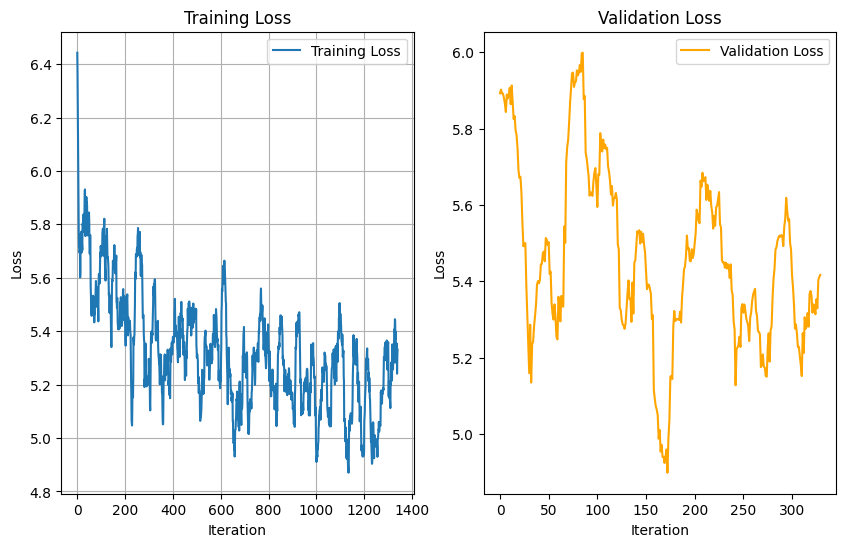

In [50]:
plot_loss(training_loss, val_loss)

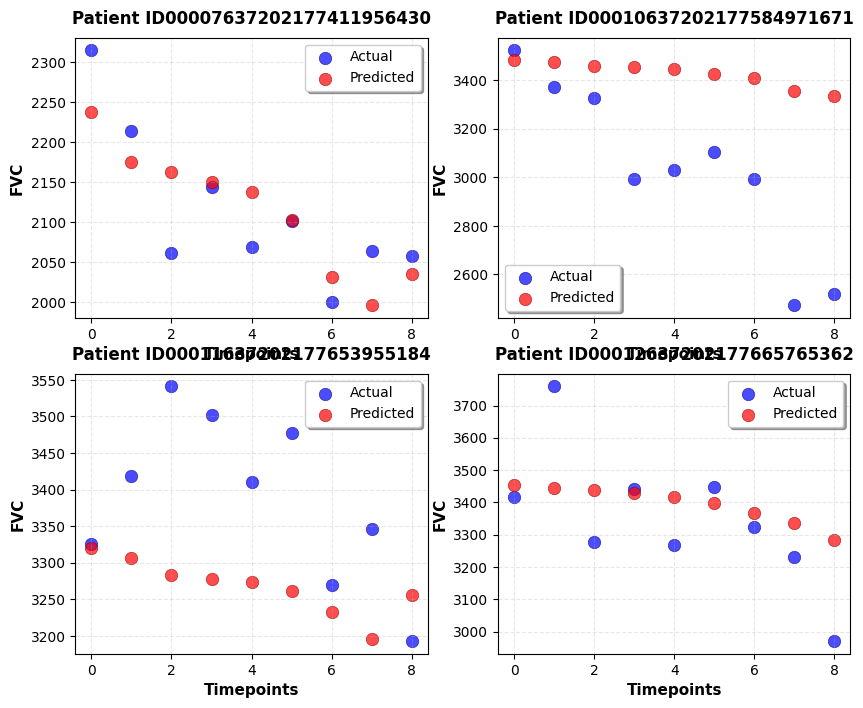

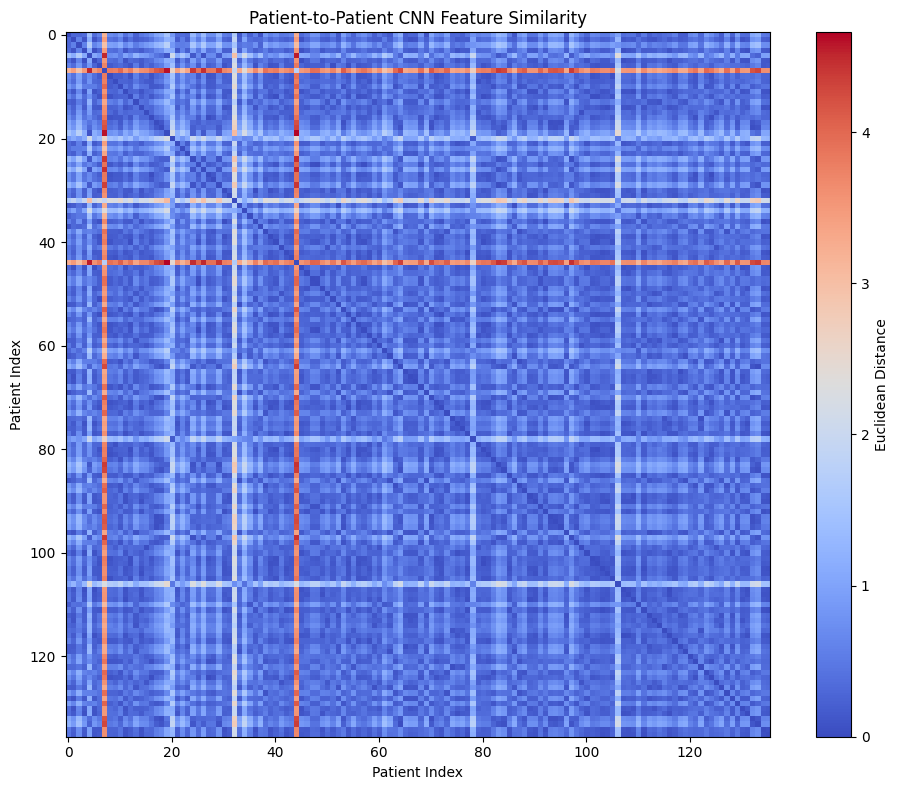

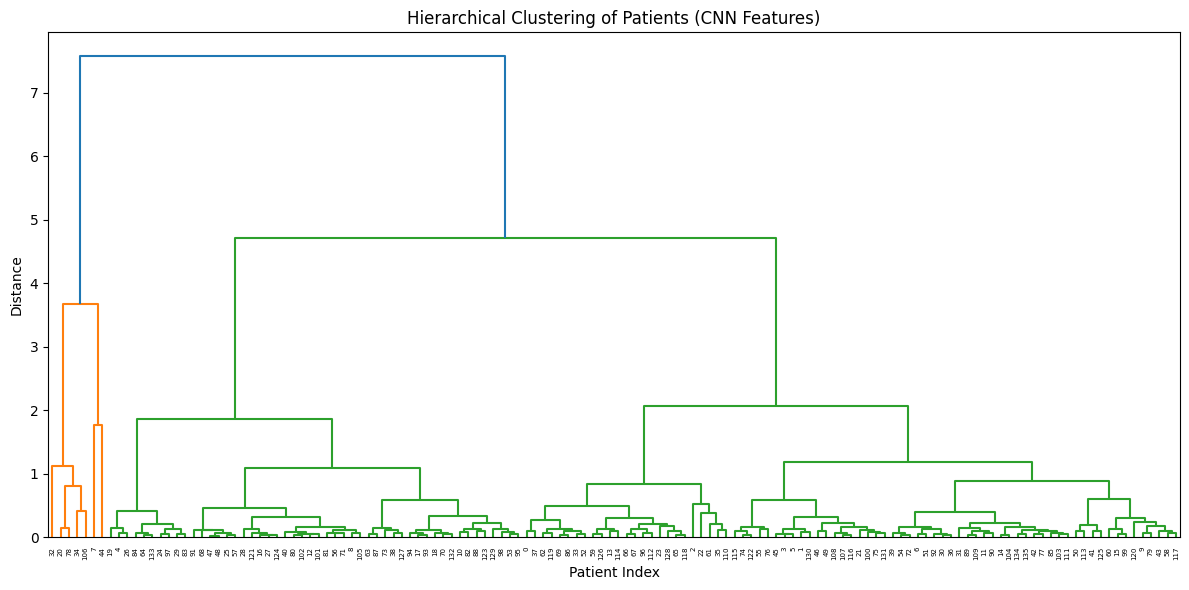

Dead features (always 0): 0/512
Feature min: -1.202
Feature max: 1.209
Feature mean: -0.000
Feature std: 0.276
Percentage of near-zero activations: 8.3%


<Figure size 640x480 with 0 Axes>

In [19]:
plot_patient_predict_samples(cnn_model, fc_model, criterion)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


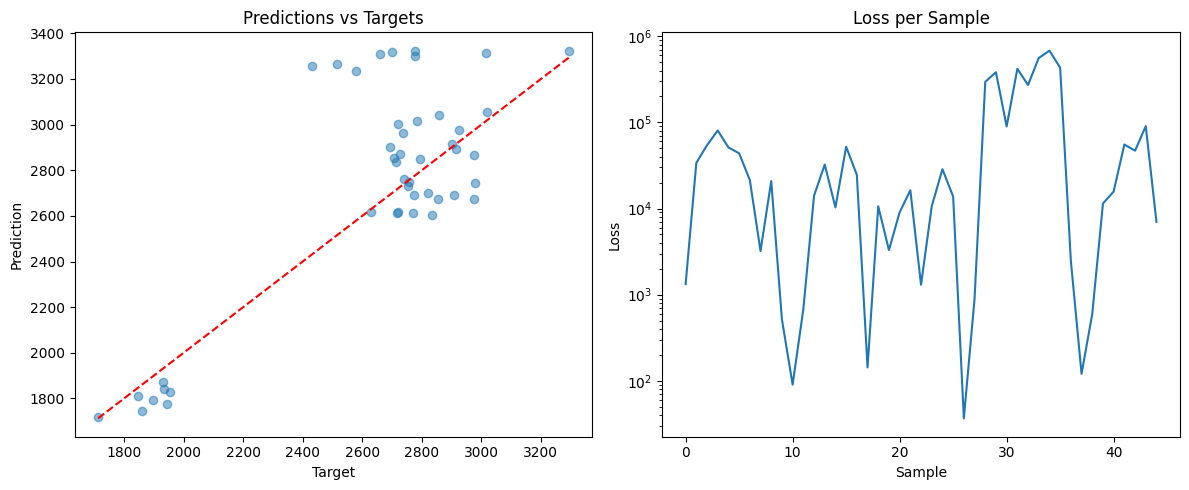

In [20]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

##### Test if model capable of overfitting (Does it have enough analysis power?)

In [30]:
def test_single_patient_overfit(cnn_model, fc_model):
    """
    Overfit test with full diagnostics
    """
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=0.00005,  # Reduced from 0.0001
    )
    criterion = nn.MSELoss()  # Simpler than Huber for debugging
    
    cnn_model.train()
    fc_model.train()
    
    # Get patient data
    patient = list(train_x.keys())[0]
    x = train_x[patient]  # List of samples
    y = train_y[patient]  # List of targets
    patient_scan_count = scan_count[patient]  # FIXED: was patient_id
    
    print(f"Patient: {patient}")
    print(f"Number of samples: {len(x)}")
    print(f"Targets: {y}")
    print(f"Scan count: {patient_scan_count}\n")
    
    # Load scans once
    scans = get_scans(patient, patient_scan_count, 64)
    print(f"Scans shape: {scans.shape}\n")
    
    for epoch in range(200):
        # Compute features once per epoch
        
        epoch_losses = []
        epoch_predictions = []
        epoch_targets = []
        
        # Train on all samples
        for i in range(len(x)):
            optimizer.zero_grad()
            features = cnn_model.forward(scans)  # (num_slices, 512)
            features = torch.mean(features, dim=0)  # (512,)
            
            # Prepare tabular inputs
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            target = torch.tensor(y[i], dtype=torch.float32, device=device)
            
            # Forward pass
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            loss = criterion(output, target)
            
            # Check for NaN/Inf
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"  [EPOCH {epoch}] NaN/Inf detected!")
                print(f"    Output: {output.item():.2f}, Target: {target.item():.2f}")
                return
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                list(cnn_model.parameters()) + list(fc_model.parameters()), 
                max_norm=1.0
            )
            
            optimizer.step()
            
            # Log
            epoch_losses.append(loss.item())
            epoch_predictions.append(output.item())
            epoch_targets.append(target.item())
        
        # Compute epoch statistics
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        max_loss = max(epoch_losses)
        min_loss = min(epoch_losses)
        
        # Print detailed diagnostics every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}:")
            print(f"  Loss: Avg={avg_loss:.2f}, Min={min_loss:.2f}, Max={max_loss:.2f}")
            print(f"  Predictions: {[f'{p:.1f}' for p in epoch_predictions]}")
            print(f"  Targets:     {[f'{t:.1f}' for t in epoch_targets]}")
            
            # Check gradient norms
            cnn_grad_norm = sum(p.grad.norm().item() for p in cnn_model.parameters() if p.grad is not None)
            fc_grad_norm = sum(p.grad.norm().item() for p in fc_model.parameters() if p.grad is not None)
            print(f"  Grad norms: CNN={cnn_grad_norm:.3f}, FC={fc_grad_norm:.3f}")
            
            # Check feature statistics
            print(f"  Feature stats: mean={features.mean().item():.3f}, std={features.std().item():.3f}")
            print()
        
        # Early stopping if converged
        if avg_loss < 1.0:
            print(f"Converged at epoch {epoch} with loss {avg_loss:.4f}")
            break

# Reset models
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
test_single_patient_overfit(cnn_model, fc_model)

Patient: ID00007637202177411956430
Number of samples: 9
Targets: [2315, 2214, 2061, 2144, 2069, 2101, 2000, 2064, 2057]
Scan count: 30

Scans shape: torch.Size([30, 1, 256, 256])

Epoch 0:
  Loss: Avg=1633136.58, Min=1.51, Max=10698515.00
  Predictions: ['1305.9', '5484.9', '3299.5', '1253.6', '1490.2', '2475.9', '2319.6', '1786.5', '2055.8']
  Targets:     ['2315.0', '2214.0', '2061.0', '2144.0', '2069.0', '2101.0', '2000.0', '2064.0', '2057.0']
  Grad norms: CNN=1.639, FC=0.791
  Feature stats: mean=0.000, std=0.836

Epoch 10:
  Loss: Avg=55290.96, Min=1985.84, Max=306702.34
  Predictions: ['1761.2', '1884.9', '2105.6', '2192.8', '2165.3', '2048.5', '2113.9', '2200.2', '2243.3']
  Targets:     ['2315.0', '2214.0', '2061.0', '2144.0', '2069.0', '2101.0', '2000.0', '2064.0', '2057.0']
  Grad norms: CNN=0.948, FC=1.422
  Feature stats: mean=0.000, std=0.741

Epoch 20:
  Loss: Avg=177404.84, Min=233.66, Max=365231.81
  Predictions: ['1774.6', '1609.7', '1568.2', '1587.5', '1660.1', '1760

### Use Imagenet's 34 Layer Implementation

In [46]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        # Imagenet 34 Layer Architecture
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
        ) * 6

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU()
        ) + nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
        ) * 11

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
        ) * 5

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
        ) * 2

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

In [58]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_imagenet.txt.txt'
criterion = nn.HuberLoss(delta=1.0)

training_loss, val_loss = train_model(cnn_model, fc_model, criterion, log_file, epoch=1, scan_batch_size=64, learning_rate=0.0001, patient_batch_size=1)

Epoch 0


  0%|          | 0/136 [00:00<?, ?it/s]

torch.Size([26, 1, 256, 256])


  1%|          | 1/136 [00:00<01:39,  1.35it/s]

torch.Size([26, 1, 256, 256])


  1%|▏         | 2/136 [00:01<01:28,  1.52it/s]

torch.Size([24, 1, 256, 256])


  2%|▏         | 3/136 [00:01<01:19,  1.67it/s]

torch.Size([30, 1, 256, 256])


  3%|▎         | 4/136 [00:02<01:26,  1.53it/s]

torch.Size([21, 1, 256, 256])


  4%|▎         | 5/136 [00:03<01:19,  1.64it/s]

torch.Size([64, 1, 256, 256])


  4%|▍         | 6/136 [00:04<01:45,  1.23it/s]

torch.Size([64, 1, 256, 256])


  5%|▌         | 7/136 [00:06<02:41,  1.25s/it]

torch.Size([64, 1, 256, 256])


  6%|▌         | 8/136 [00:07<02:42,  1.27s/it]

torch.Size([64, 1, 256, 256])


  7%|▋         | 9/136 [00:09<02:49,  1.34s/it]

torch.Size([62, 1, 256, 256])


  7%|▋         | 10/136 [00:10<02:52,  1.37s/it]

torch.Size([64, 1, 256, 256])


  8%|▊         | 11/136 [00:12<02:52,  1.38s/it]

torch.Size([30, 1, 256, 256])


  9%|▉         | 12/136 [00:12<02:27,  1.19s/it]

torch.Size([64, 1, 256, 256])


 10%|▉         | 13/136 [00:14<02:46,  1.35s/it]

torch.Size([64, 1, 256, 256])


 10%|█         | 14/136 [00:16<02:51,  1.41s/it]

torch.Size([64, 1, 256, 256])


 11%|█         | 15/136 [00:18<03:36,  1.79s/it]

torch.Size([64, 1, 256, 256])


 12%|█▏        | 16/136 [00:21<03:49,  1.91s/it]

torch.Size([64, 1, 256, 256])


 12%|█▏        | 16/136 [00:21<02:42,  1.36s/it]


KeyboardInterrupt: 

Epoch 0


100%|██████████| 136/136 [01:42<00:00,  1.33it/s]


Epoch 0 completed
Training Loss: 200699.25884288986
Validation Loss: 66909.57344037824
Epoch 1


100%|██████████| 136/136 [01:41<00:00,  1.34it/s]


Epoch 1 completed
Training Loss: 131343.2174662484
Validation Loss: 41208.12258107397
Epoch 2


100%|██████████| 136/136 [01:40<00:00,  1.35it/s]


Epoch 2 completed
Training Loss: 429064.65835767426
Validation Loss: 43004.54604699029


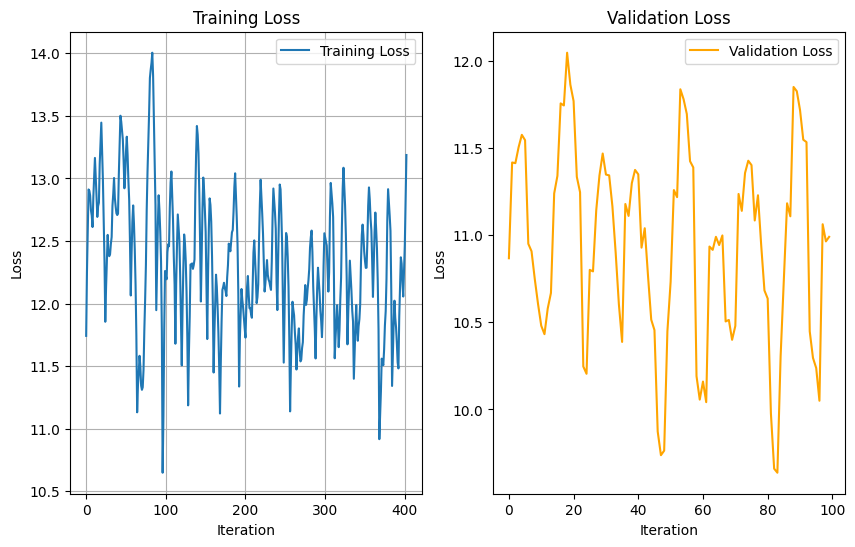

In [24]:
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=3, scan_batch_size=64)
plot_loss(training_loss, val_loss)

In [26]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
for i in range(len(test_prediction)):
    print(test_prediction[i], test_target[i], loss(test_prediction[i], test_target[i]))

100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

tensor(2955.2466) tensor(3020) tensor(4193.0054)
tensor(2955.3071) tensor(2859) tensor(9275.0635)
tensor(2955.4287) tensor(2783) tensor(29731.6602)
tensor(2955.4895) tensor(2719) tensor(55927.2852)
tensor(2955.6719) tensor(2738) tensor(47381.0469)
tensor(2955.9761) tensor(2694) tensor(68631.4609)
tensor(2956.7661) tensor(2708) tensor(61884.5781)
tensor(2957.4958) tensor(2793) tensor(27058.8848)
tensor(2958.4692) tensor(2727) tensor(53578.0078)
tensor(2685.3762) tensor(2739) tensor(2875.5098)
tensor(2685.4978) tensor(2756) tensor(4970.5601)
tensor(2685.6194) tensor(2755) tensor(4813.6699)
tensor(2685.7412) tensor(2820) tensor(18025.4219)
tensor(2685.8623) tensor(2853) tensor(27935.0098)
tensor(2686.2275) tensor(2716) tensor(886.3994)
tensor(2686.9570) tensor(2833) tensor(21328.5488)
tensor(2687.7480) tensor(2771) tensor(6930.8877)
tensor(2688.7222) tensor(2628) tensor(3687.1816)
tensor(2688.7222) tensor(2719) tensor(916.7471)
tensor(1889.9749) tensor(1930) tensor(1602.0123)
tensor(1890.

### Add Residual Connections

In [29]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.input_conv(x))
        x = self.second_conv(x)
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

In [30]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=15)
plot_loss(training_loss, val_loss)

Epoch 0


100%|██████████| 136/136 [01:14<00:00,  1.82it/s]


Epoch 0 completed
Training Loss: 26451691.340833332
Validation Loss: 6375088.70625
Epoch 1


100%|██████████| 136/136 [01:07<00:00,  2.03it/s]


Epoch 1 completed
Training Loss: 10313839.908881972
Validation Loss: 1796454.9068446183
Epoch 2


100%|██████████| 136/136 [01:07<00:00,  2.01it/s]


Epoch 2 completed
Training Loss: 512546.4486246215
Validation Loss: 149511.6941560491
Epoch 3


100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Epoch 3 completed
Training Loss: 386953.0833448546
Validation Loss: 49395.72341920773
Epoch 4


100%|██████████| 136/136 [01:07<00:00,  2.03it/s]


Epoch 4 completed
Training Loss: 289783.0297261499
Validation Loss: 41739.187607805994
Epoch 5


100%|██████████| 136/136 [01:05<00:00,  2.07it/s]


Epoch 5 completed
Training Loss: 256691.3147747193
Validation Loss: 41653.05153889974
Epoch 6


100%|██████████| 136/136 [01:05<00:00,  2.08it/s]


Epoch 6 completed
Training Loss: 289105.40028264787
Validation Loss: 41814.991475703515
Epoch 7


100%|██████████| 136/136 [01:05<00:00,  2.08it/s]


Epoch 7 completed
Training Loss: 523477.94424128265
Validation Loss: 41554.720673802694
Epoch 8


100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Epoch 8 completed
Training Loss: 209136.86293978425
Validation Loss: 43571.092537344826
Epoch 9


100%|██████████| 136/136 [01:06<00:00,  2.03it/s]


Epoch 9 completed
Training Loss: 320754.6967118403
Validation Loss: 41783.48280666775
Epoch 10


100%|██████████| 136/136 [01:06<00:00,  2.03it/s]


Epoch 10 completed
Training Loss: 198838.48275851022
Validation Loss: 41443.26922769123
Epoch 11


 75%|███████▌  | 102/136 [00:50<00:16,  2.02it/s]


KeyboardInterrupt: 

### Use Batchnorm to stabilize weights

In [ ]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    # Add batchnorm
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.bn2(self.second_conv(x))
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

In [32]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_bn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8, scan_batch_size=64)
plot_loss(training_loss, val_loss)

Epoch 0


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 0 completed
Training Loss: 10171419.402083334
Validation Loss: 1875273.3816529675
Epoch 1


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 1 completed
Training Loss: 1123270.351906467
Validation Loss: 154460.3026026747
Epoch 2


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 2 completed
Training Loss: 175707.74175649483
Validation Loss: 47230.468333183926
Epoch 3


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 3 completed
Training Loss: 195772.04956602785
Validation Loss: 42923.509592605165
Epoch 4


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 4 completed
Training Loss: 311440.4012515108
Validation Loss: 43370.545636223294
Epoch 5


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 5 completed
Training Loss: 240874.33300282937
Validation Loss: 43510.99670375612
Epoch 6


 74%|███████▍  | 101/136 [01:27<00:30,  1.15it/s]


KeyboardInterrupt: 

### Use Bottleneck blocks

In [11]:
from torch import nn
import torch.nn.functional as F

class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 23)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(x.size(0), -1)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=2048+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 0


100%|██████████| 136/136 [06:05<00:00,  2.69s/it]


Epoch 0 completed
Training Loss: 667819.0930362048
Validation Loss: 97155.5853611056
Epoch 1


100%|██████████| 136/136 [06:16<00:00,  2.77s/it]


Epoch 1 completed
Training Loss: 209757.71511391798
Validation Loss: 46256.967478790284
Epoch 2


100%|██████████| 136/136 [06:18<00:00,  2.79s/it]


Epoch 2 completed
Training Loss: 148185.1695085537
Validation Loss: 44207.440449318354
Epoch 3


100%|██████████| 136/136 [06:30<00:00,  2.87s/it]


Epoch 3 completed
Training Loss: 290834.1511991519
Validation Loss: 40749.76325650778
Epoch 4


100%|██████████| 136/136 [06:28<00:00,  2.86s/it]


Epoch 4 completed
Training Loss: 270430.78575109807
Validation Loss: 44281.47471906851
Epoch 5


100%|██████████| 136/136 [05:58<00:00,  2.64s/it]


Epoch 5 completed
Training Loss: 325952.886311521
Validation Loss: 42322.56000130124


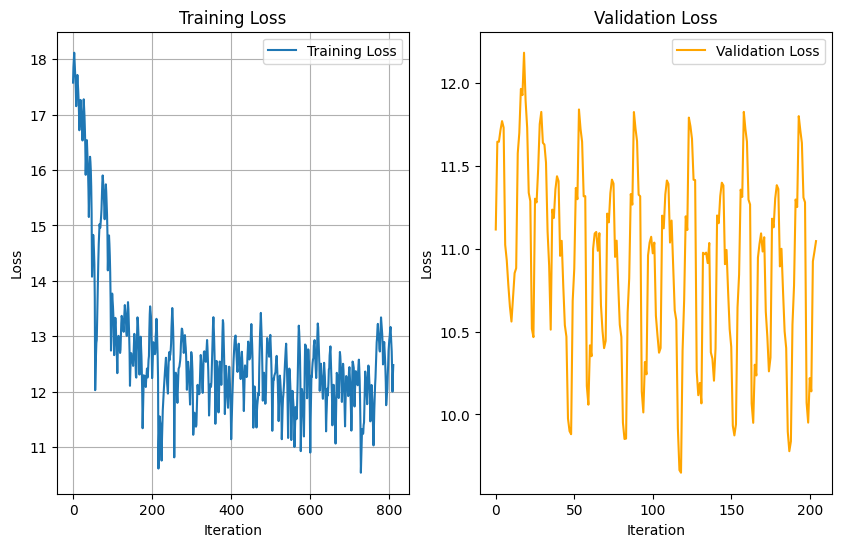

In [12]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_152.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=6, scan_batch_size=64)
plot_loss(training_loss, val_loss)

### Analyze top and bottom half of lung separately

In [10]:
from torch import nn
import torch.nn.functional as F

from torch import nn
import torch.nn.functional as F


class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False, dropout_rate=0.1):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.dropout(x)
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256, dropout_rate=0.1):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 6)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_final = nn.Dropout(p=dropout_rate * 2)

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True, dropout_rate=self.dropout_rate)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1, dropout_rate=self.dropout_rate) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)
        x = self.dropout_final(x)

        return x

class FCLayer(nn.Module):
    def __init__(self, partition_count, dropout_rate=0.3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(512 * partition_count + 3, 512 * partition_count // 4)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512 * partition_count // 4, 100)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_scans(patient_id: str, patient_scan_count: int, partition_count: int, scan_batch_size: int) -> torch.Tensor:
    scans = []
    scan_per_partition = math.floor(patient_scan_count / partition_count)
    for part_idx in range(partition_count):
        partition = []
        part_start, part_end = part_idx * scan_per_partition, (part_idx + 1) * scan_per_partition
        skip_size = max(1, round(scan_per_partition / scan_batch_size))
        for scan_idx in range(part_start, part_end, skip_size):
            scan = get_preprocessed_scan(data_dir, patient_id, scan_idx)
            if scan is None:
                continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            partition.append(scan)
        scans.append(torch.stack(partition))
    return scans

def train_model(cnn_model: CNN, fc_model: FCLayer, log_file: str, epoch=6, learning_rate=0.001, partition_count=2, scan_batch_size=32):
    torch.cuda.empty_cache()

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        # accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            # if patient_count % 4 == 0:
            #     optimizer.zero_grad()
            #     accum_loss = 0

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)


            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate loss for stat purpose
            accum_loss = 0

            # For each datapoint, forward pass and backward pass
            for i in range(len(x)):
                optimizer.zero_grad()

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                # accum_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss.backward()
                optimizer.step()
                accum_loss += loss.item()


            # accum_loss.backward()
            # optimizer.step()
            training_loss.append(accum_loss / max(len(x), 1))
            
            if patient_count == 130:
                print(f"Feature mean: {features.mean():.4f}")
                print(f"Feature std: {features.std():.4f}")
            patient_count += 1
            # Update parameters based on batch of 8 patients
            # if patient_count % 4 == 3:
            #     accum_loss.backward()
            #     optimizer.step()
            #     print(f"Feature mean: {features.mean():.4f}")
            #     print(f"Feature std: {features.std():.4f}")
            #     with open(log_file, "a") as f:
            #         f.write(f"Epoch {epoch}, Loss: {accum_loss.item() / max(len(x), 1)}\n")
            #         training_loss.append(accum_loss / max(len(x), 1))
            #     del accum_loss
            # patient_count += 1
            

        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, accum_loss
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list(val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [12]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_models, fc_model, partition_count=2, scan_batch_size=64):
    for cnn_model in cnn_models:
        cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)
        features = []
        for i in range(partition_count):
            feature = cnn_models[i].forward(scans[i])
            features.append(torch.mean(feature, dim=0))
        features = torch.cat(features, dim=0).flatten()

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

Epoch 0


 96%|█████████▋| 131/136 [04:55<00:10,  2.07s/it]

Feature mean: 0.3726
Feature std: 0.0618


100%|██████████| 136/136 [05:07<00:00,  2.26s/it]


Epoch 0 completed
Training Loss: 155185.12353634305
Validation Loss: 179111.58716387922
Epoch 1


 96%|█████████▋| 131/136 [04:24<00:11,  2.29s/it]

Feature mean: 0.2328
Feature std: 0.0434


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 1 completed
Training Loss: 129201.75251117055
Validation Loss: 245942.50359031782
Epoch 2


 96%|█████████▋| 131/136 [04:23<00:10,  2.15s/it]

Feature mean: 0.1256
Feature std: 0.0294


100%|██████████| 136/136 [04:34<00:00,  2.01s/it]


Epoch 2 completed
Training Loss: 203600.0089995999
Validation Loss: 180476.9363442858
Epoch 3


 96%|█████████▋| 131/136 [04:23<00:09,  1.89s/it]

Feature mean: 0.6432
Feature std: 0.0568


100%|██████████| 136/136 [04:33<00:00,  2.01s/it]


Epoch 3 completed
Training Loss: 178461.12029605443
Validation Loss: 178910.1704472754
Epoch 4


 96%|█████████▋| 131/136 [04:26<00:07,  1.48s/it]

Feature mean: 0.0780
Feature std: 0.0302


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 4 completed
Training Loss: 201670.3846994916
Validation Loss: 186100.09874464248
Epoch 5


 96%|█████████▋| 131/136 [04:24<00:06,  1.28s/it]

Feature mean: 0.0459
Feature std: 0.0209


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 5 completed
Training Loss: 133576.05266017278
Validation Loss: 164550.67864883423
Epoch 6


 96%|█████████▋| 131/136 [04:25<00:12,  2.40s/it]

Feature mean: 0.0490
Feature std: 0.0177


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 6 completed
Training Loss: 179841.28394714356
Validation Loss: 252408.94001993816
Epoch 7


 96%|█████████▋| 131/136 [04:25<00:09,  1.93s/it]

Feature mean: 0.0113
Feature std: 0.0077


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 7 completed
Training Loss: 135129.31214817593
Validation Loss: 246303.93169339924
Epoch 8


 96%|█████████▋| 131/136 [04:25<00:09,  1.88s/it]

Feature mean: 0.0109
Feature std: 0.0098


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 8 completed
Training Loss: 168431.17493760266
Validation Loss: 217720.31133607653
Epoch 9


 96%|█████████▋| 131/136 [04:21<00:09,  1.99s/it]

Feature mean: 0.0040
Feature std: 0.0069


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 9 completed
Training Loss: 126111.29242416487
Validation Loss: 219540.72166845325


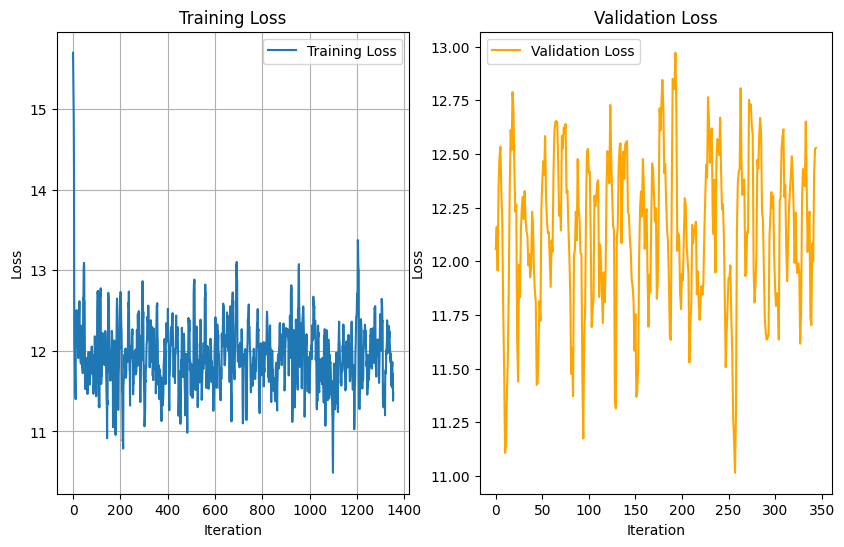

In [14]:
log_file = 'training_log_top_bottom_analysis.txt'

partition_count = 1

# cnn_models = [CNN().to(device) for _ in range(partition_count)]
cnn_model = CNN().to(device)
fc_model = FCLayer(partition_count).to(device)

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, partition_count=1, scan_batch_size=64)
plot_loss(training_loss, val_loss)

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


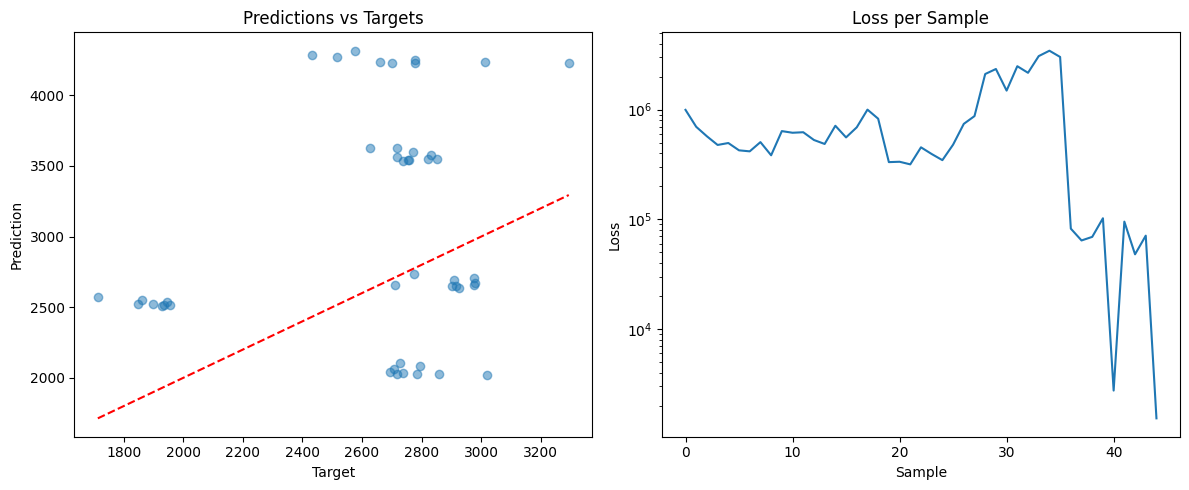

In [24]:
test_prediction, test_target = test_model(cnn_models, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

In [17]:
predictions = test_prediction
targets = test_target
# 1. Check if model is just predicting initial_FVC
print("Correlation between predictions and initial_FVC:")
initial_fvc_vals = [val_x[pid][i]['initial_FVC'] for pid in val_x.keys() for i in range(len(val_x[pid]))]
print(f"Corr(pred, initial_FVC): {np.corrcoef(predictions, initial_fvc_vals)[0,1]:.4f}")
print(f"Corr(pred, targets): {np.corrcoef(predictions, targets)[0,1]:.4f}")

# 2. Check unique prediction values (should be many, not just a few)
unique_preds = np.unique(np.round(predictions, -1))  # Round to nearest 10
print(f"Number of distinct prediction values (±10ml): {len(unique_preds)}")
print(f"Most common predictions: {np.round(np.bincount(np.round(predictions).astype(int)).argsort()[-5:], -1)}")

# 3. Baseline comparison
baseline_predictions = initial_fvc_vals  # Just predict initial_FVC
baseline_mae = np.mean(np.abs(np.array(targets) - np.array(baseline_predictions)))
model_mae = np.mean(np.abs(np.array(targets) - np.array(predictions)))
print(f"Baseline MAE (just initial_FVC): {baseline_mae:.1f}")
print(f"Model MAE: {model_mae:.1f}")
print(f"Improvement: {baseline_mae - model_mae:.1f} ml")

# 4. Check prediction variance
print(f"Target std: {np.std(targets):.1f}")
print(f"Prediction std: {np.std(predictions):.1f}")
# If prediction std << target std, model is underconfident/conservativepse
# 4. **Try simpler baseline** - predict `initial_FVC + weeks * learned_rate` to establish lower bound
# 5. **Increase FC layer depth** - add 1-2 more layers with dropout
# 6. **Use Huber loss instead of MSE** - more robust to outliers
# 7. **Add learning rate scheduler** - may be stuck in local minimum

# The horizontal banding is the **clearest signal** that your model has collapsed to predicting only a few discrete values rather than learning continuous relationships. This is often caused by incorrect gradient flow (like `retain_graph=True` issue) or insufficient model capacity in the FC layers.

Correlation between predictions and initial_FVC:


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 45 and the array at index 1 has size 314